In [23]:
#
# import utilitaires
#
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

import helpers as hlp
import helpers.dataset.PlantVillage as pv
import helpers.features as feat
import helpers.visual_words as vw

In [24]:
#
# dataset PlantVillage
#
config_overrides = hlp.MetaObject.from_json("config_overrides.json")

pv_config = pv.Config()
if not config_overrides is None:
    hlp.MetaObject.override_from_object(pv_config, 
                                        config_overrides.dataset)

pv_dataset = pv.load(pv_config)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)


#
# features extraction orb
#
orb_features_config = feat.OrbFeaturesConfig()
if not orb_features_config is None:
    hlp.MetaObject.override_from_object(orb_features_config, 
                                        config_overrides.orb.features)

    
#
# bag of visual words orb
#
orb_bovw_config = vw.BoVWConfig()
if not config_overrides is None:
    hlp.MetaObject.override_from_object(orb_bovw_config, 
                                        config_overrides.orb.bovw)

orb_bovw = vw.load_bovw(orb_bovw_config, None)
orb_bovw_cluster_count = orb_bovw.model.cluster_centers_.shape[0]

print("ORB BoVW clusters:", orb_bovw.model.cluster_centers_.shape)


#
# objet wrapper qui permet de tout processer
#
orb_visual_words = vw.VisualWords(orb_features_config, orb_bovw.model)

Dataset (60343, 5)
ORB BoVW clusters: (500, 32)


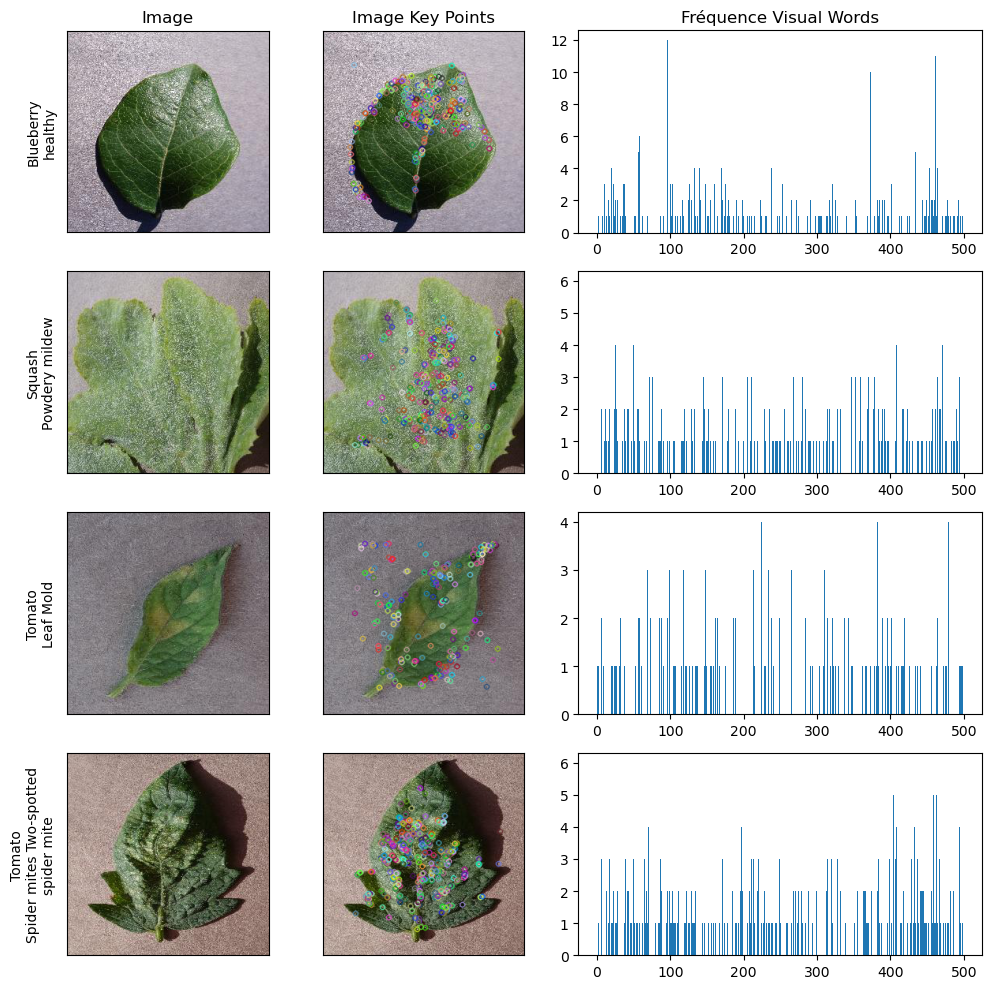

In [27]:
#
# visualiser quelques orb keypoints
#
SAMPLES_GRID = (4, 3)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

# selectionner quelques images aleatoirement
random.seed(72)
image_indices = random.sample(range(pv_dataframe.shape[0]), SAMPLES_COUNT)
image_indices.sort()

x_range = range(orb_bovw_cluster_count)
figure, axes = plt.subplots(SAMPLES_GRID[0], 
                            SAMPLES_GRID[1], 
                            figsize=FIGSIZE,
                            width_ratios=[1, 1, 2])

for i, image_index in enumerate(image_indices):
    image = pv_dataset.get_image(image_index)
    key_points, features, visual_words_freq = orb_visual_words.extract(image)
    
    if key_points is None:
        continue
    
    image_key_points = orb_visual_words.draw_key_points(image, key_points)
    
    species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
    disease = pv.attribute_prettify(species, disease)
    title = "\n".join([species, disease])
    
    plt.sca(axes[i, 0])
    plt.gca().set_ylabel(title)
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.imshow(image)
    
    plt.sca(axes[i, 1])    
    plt.gca().set_xticks([])
    plt.gca().set_yticks([])
    plt.imshow(image_key_points)
    
    plt.sca(axes[i, 2])
    plt.bar(x_range, visual_words_freq)

axes[0, 0].set_title("Image")
axes[0, 1].set_title("Image Key Points")
axes[0, 2].set_title("Fréquence Visual Words")

plt.tight_layout()
plt.show()

# figure.savefig('visual_words.png')